# Acoustic Array Design

This document introduces and covers the design of an acoustic phased interferometer array

Lets first start with some generic python imports to get the project going

In [54]:
import matplotlib.pyplot  as plt
import numpy as np

## Array Requirements

Now that that is out the way lets decide on some important parameters and physical realities. These include the following:

- Minimum frequency of interest $f_{min}$
- Maximum frequency of interest $f_{max}$
- The set of Angles of Arrival($AOA$) of interest - lets call this 0 - 180 degrees for now
- The velocity of sound (in this case in water) $v$

This is important: Note that when one refers to the $AOA$. This is the angle relative to the boresight of the receiver as shown below
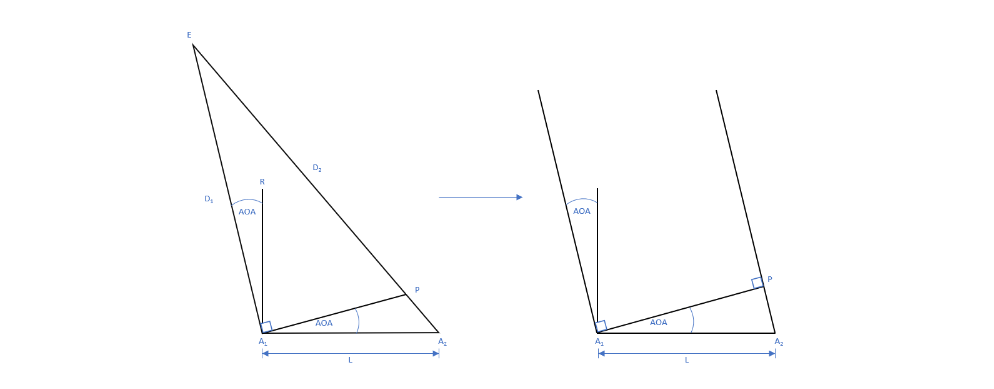

This same geometry may be used to derive equations that shall be used but the purposes of this document the proof is omitted.

lets try keep everything in SI units and describe them as follows:

In [55]:
f_min = 500 # Hz
f_max = 20000 # Hz
AOA_required = [0, 180]
v = 1500 # m/s

## Angle of Arrival Theory

Note that none of the previously defined parameter describe the receiver array. 

To begin this process by defining an array with only 2 microphones. Lets go on to call the distance between these 2 microphones $L$

The question is the following: For a given array length L and differential phase between the two microphones. What is the $AOA$?

Note: There is a bit of a simplification here. When I say the differential phase between two microphones what I actually mean is the following: The differential phase as a result of a complex division of the complex numbers (at a particular frequency) that are the output of the fourier transform of both time domain signals from each receiver.  

Neglecting the proof the relationship between the $AOA$, the differential phase $\Delta \phi$ and the baseline distance (the distance between the two microphones) is as follows:

$AOA = sin^{-1}(\frac{\lambda (\frac{\Delta \phi}{2\pi} + I)}{L})$

At this point $I$ has not been discussed. This is the ambiguity number. On a qualitative level, this figure describes by what factor the baseline distance is larger than the wavelength of interest. This becomes an issue if the baseline distance is larger the half the wavelength of interest. This will in turn cause phase wrapping


## Ambiguity Example

Lets deviate from out own parameters for a moment and say our frequencies of interest are as follows:

- $f_{lower} = 1000 Hz$
- $f_{upper} = 10000 Hz$

Lets call the velocity of the medium $1500 m/s$, i.e:

- $v_example = 1500$

and lets call the baseline distance half the wavelength of $f_{lower}$, i.e the baseline distance is as follows:

- $L = \frac{\lambda}{2} = \frac{v}{2f} = \frac{1500}{1000*2} = 0.5m$

Lets use this distance to calculate the differential phase between two receivers separated by this distance.

Note that this requires us to do the following:

- Generate an array for all $AOAs$, i.e $ [-180:180]$
- solve - $AOA = sin^{-1}(\frac{\lambda (\frac{\Delta \phi}{2\pi} + I)}{L})$ - for $\phi$
- And compute $\phi$ for both frequencies, $1000 Hz$ and $10000 Hz$

Note that solving the above formula for $\phi$ results in:


Note: Using angles of arrival grater than $[-60:60]$  moves one into a nonlinear region of this equation. All signals are assumed to arrive within these bounds


Text(0.5, 1.0, 'Plot Showing Differential Phase as a Function of AOA Frequency')

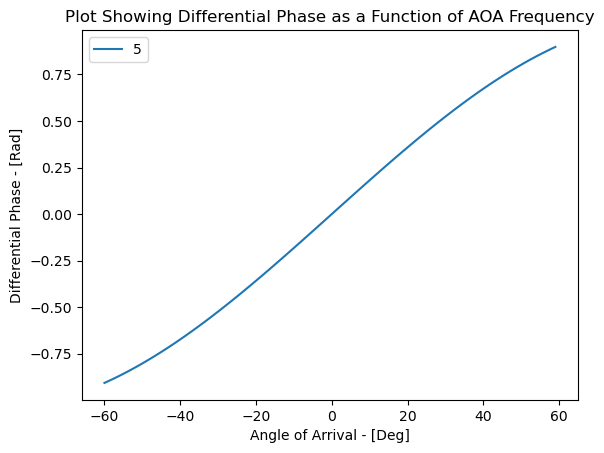

In [56]:

def AngleOfArrivalToDifferentialPhase(L_m, v_mps, f_hz, AOAs_rad):
    """
    Calculate the expected differential phase as a function of AOA, L, v and f

    Parameters
    L_m - Baseline length in meters
    v_mps - Velocity of propagation  in meters per second
    f_hz - Frequency of interest in hertz
    AOAs_rad - Array of angle of arrivals in radians
    """

    lambda_m = v_mps/f_hz

    # Generic Calculations
    intermediate_coefficient = np.divide(L_m*2*np.pi,lambda_m) # verified
    differential_phase_output_rad = np.sin(AOAs_rad)*intermediate_coefficient

    #differential_phases_rads = np.multiply(np.sin(AOAs_rad),())*2*np.pi
    scaled_differential_phase_output_rad = np.mod(differential_phase_output_rad + np.pi, 2*np.pi) - np.pi

    return scaled_differential_phase_output_rad

AOAs_deg = np.arange(-60, 60, 1)
AOAs_rad = AOAs_deg*np.pi/180

L_m = 0.5
v_mps = 1500
f_hz = 500

differential_phases_rads = AngleOfArrivalToDifferentialPhase(L_m, v_mps, f_hz, AOAs_rad)

plt.plot(AOAs_deg, differential_phases_rads)
plt.xlabel("Angle of Arrival - [Deg]")
plt.ylabel("Differential Phase - [Rad]")
plt.legend("500 Hz")
plt.title("Plot Showing Differential Phase as a Function of AOA Frequency")

So what does this show?

As expected for a lower frequency wave, there is no ambiguity. For angles of arrival between $-60$ and $60$ degrees there is a one to one mapping between the $AOA$ and differential phase between channels.

The $10000 Hz$ plot is slightly more complicated. There appears to be ambiguity in while attempting to determine the angle of arrival. Simply put, for a specific differential phase there are **multiple possible angles of arrival**. This occurs because the baseline distance is larger than a half wavelength.

## Designing an Array

This is new territory but lets try design an unambiguous array for a set of frequencies



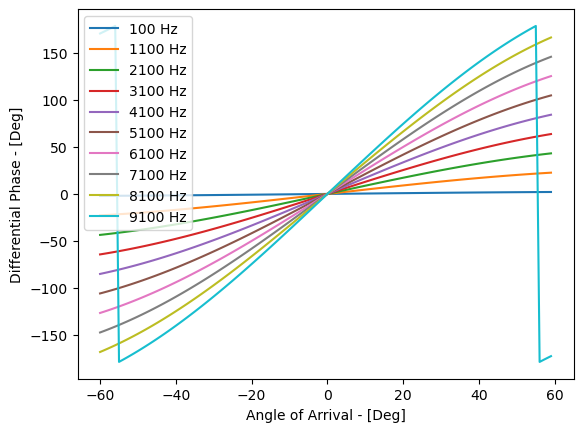

In [87]:
f, ax = plt.subplots(1)

AOAs_axis_deg = np.arange(-60, 60, 1)
AOAs_axis_rad = AOAs_axis_deg*np.pi/180

base_freq = 500
L_m = 0.1
v_mps = 1500
f_hz = 100

legend_strings = []
for i in range(1,100,10):
    diff_phases_rads = AngleOfArrivalToDifferentialPhase(L_m, v_mps, f_hz*i, AOAs_axis_rad)
    ax.plot(AOAs_axis_deg, diff_phases_rads*180/np.pi)
    legend_strings.append(str(f_hz*i) + " Hz")

plt.xlabel("Angle of Arrival - [Deg]")
plt.ylabel("Differential Phase - [Deg]")
plt.legend(legend_strings)

## Beamforming

If I have the two channels already, can I not sum them to gain gain in along [-60:60] and increase rejection outside of these angles?

# Open Questions

- How does one ensure that there is no ambiguity? It is all good an well to say this thing works over these angles but how does that relate toa real system?

>- One can create a lookup table to constrain the angle of arrival for a frequency


## Angle Of Arrival Methodology

1. Apply threshold detection
2. Extract frequencies of interest
3. Compute the complex differential phase

>- At this point one may or may not have ambiguous angle of arrivals
>- For a 2 element array there is no way to resolve these ambiguities
>- 10 cm looks good

4. 